# Predicting near future highs and lows.

In order to determine whether we are currently experiencing a pump, this notebook tries to predict the high one timestep into the future (more precisely, we try to predict the logarithm of the quotient of the high of the next timestep over the closing price of the current timestep). As we can easily resample the data and change the length of the timesteps, doing this successfully would not only tell us whether or not there currently is a pump, but also how long it is expected to last. 

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import log, sin , cos, pi
import numpy as np
import os

In [2]:
tf.__version__

'2.1.0'

In [3]:
#!pip install tf-nightly

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

My data comes with headers: a timestamp in Unix time (in milliseconds), as well as 'O', 'H', 'L', 'C', 'V'. The 'timestamp' column contains time indices in exact one-minute steps, without any gaps (although there are some missing values in the remaining columns)

In [5]:
def load_df(path):
    """
    input : 
           path - string which indicates where csv file is located. 
           
    output :
           df - convert csv to df and counts the total NaN in the dataframe. 
    """
    df = pd.read_csv(path)
    df.columns = ['timestamp','O','H','L','C','V']
    df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms')
    df = df.set_index(pd.DatetimeIndex(df['datetime']))
    df = df.drop(['datetime'],axis = 1)        
    df['returns'] = df['O'].pct_change()
    print('Total NaN : ' + "\n")
    print(df.isna().sum())
    print('')
    return(df)

In [6]:
#OHLCV=pd.read_csv('./crypto_pumps/data/raw/Binance/BTC_USDT.csv')
#OHLCV.loc[:,'datetime']=pd.to_datetime(OHLCV.timestamp, unit='ms')
#OHLCV=OHLCV.set_index('datetime')

In [7]:
OHLCV = load_df('./crypto_pumps/data/raw/Binance/BTC_USDT.csv')
OHLCV = OHLCV.drop(['returns'],axis = 1)
OHLCV

Total NaN : 

timestamp    0
O            0
H            0
L            0
C            0
V            0
returns      1
dtype: int64



,timestamp,O,H,L,C,V
datetime,,,,,,
2018-02-09 10:00:14.789,1518170414789,8230.46,8317.74,8230.45,8317.74,91.494282
2018-02-09 10:01:14.789,1518170474789,8304.00,8369.00,8304.00,8350.00,131.872916
2018-02-09 10:02:14.789,1518170534789,8346.50,8380.00,8330.00,8380.00,84.544616
2018-02-09 10:03:14.789,1518170594789,8379.00,8390.00,8348.00,8360.02,112.940304
2018-02-09 10:04:14.789,1518170654789,8350.04,8389.00,8348.00,8348.13,88.138218
...,...,...,...,...,...,...
2021-02-08 11:55:00.000,1612785300000,39390.84,39394.98,39370.00,39393.27,25.544486
2021-02-08 11:56:00.000,1612785360000,39393.27,39413.00,39375.00,39402.43,35.363344
2021-02-08 11:57:00.000,1612785420000,39402.44,39404.12,39383.52,39395.32,26.575566


## Preprocessing, window creation, and model specification

This section contains the methods used to create the test datasets and to fit the models. The models are relatively simple, with a single LSTM layer.

*data_preprocessing* resamples the data, replaces C by log returns on the closing price, normalizes the OHL columns with respect to the previous value of C, normalizes the volume based on a rolling median, encodes the time of day, and adds several columns for rolling averages of log returns with varying window lengths.

*get_windows* produces window-target pairs using tf.keras.preprocessing.timeseries_dataset_from_array

*lstm_model* compiles an LSTM network with a single LSTM layer.

*fit_lstm_model* combines the previous methods and fits an LSTM network to the window-target pairs generated from the preprocessed data.

In [8]:
def data_preprocessing(in_data, sample_rate='1min'):
    
    """
    Input: 
        - in_data: Dataframe with OHLCV data, indexed by datetime and with columns including 
          timestamp (unix time in lm), O, H, L, C, V. Indices should be with 1min frequency 
          without missing values.
        - sample_rate: the sampling rate used to down-sample. E.g '1h' for one hour.
    """
    
    # impute missing values
    out_data= in_data.loc[:,['timestamp', 'O', 'H', 'L', 'C', 'V']].copy()
    out_data.loc[:,'C']=out_data.loc[:,'C'].fillna(method='ffill')
    out_data.loc[:,'V']=out_data.loc[:,'V'].fillna(0)
    out_data=out_data.fillna(method='bfill',axis=0)
    
    # resample
    out_data=out_data.resample(sample_rate,origin='start',label='left', closed='left').agg(
                                                            {'timestamp':'first',
                                                             'O':'first', 
                                                             'H':'max', 
                                                             'L':'min', 
                                                             'C':'last', 
                                                             'V':'sum'})
    out_data.drop(index=out_data.index[0], inplace=True)
    time_delta= (out_data.timestamp[1]-out_data.timestamp[0])/60000
        
    # add normalized volume
    days_30=int(43200/time_delta)
    log_volume=out_data.V.map(lambda x:log(x+1e-10))
    rolling_25=log_volume.rolling(days_30).quantile(0.25).fillna(method='bfill')
    rolling_50=log_volume.rolling(days_30).median().fillna(method='bfill')
    rolling_75=log_volume.rolling(days_30).quantile(0.75).fillna(method='bfill')
    log_volume_normal=(log_volume-rolling_50)/(rolling_75-rolling_25)
    out_data.loc[:,'normalized_volume']=log_volume_normal
    
    # add log returns (of closing prices)
    out_data.loc[:,'C_log_return']=out_data.C.map(log).diff()
    
    # normalize open, high, and low with respect to previous closing price
    log_C=out_data.C.map(log).shift(1)
    for col in ['O','H','L']:        
        out_data.loc[:,'log_'+col]= out_data.loc[:,col].map(log)-log_C
        
    # add two columns encoding the time of day
    day= 60000*60*24
    daytime= (out_data.timestamp % day)/day*2*pi
    out_data.loc[:,'time_of_day_1']= daytime.map(cos)
    out_data.loc[:,'time_of_day_2']= daytime.map(sin)   
    
    # add columns with rolling means
    for time in [3*60,12*60,24*60,3*24*60, 7*24*60 ]:
        if time>=2*time_delta:
            window=int(time/time_delta)
            out_data.loc[:,'rolling_returns_mean_'+str(time)]=out_data.C_log_return.rolling(window).mean()
        
    # add the target. At the moment this is the log_H column one time-step ahead.
    out_data.loc[:,'target']=out_data.log_H.shift(-1)
    
    # delete rows with missing entries and the O, H, L, C, V columns
    out_data.dropna(inplace=True, axis=0)
    out_data.drop(columns=['O','H','L','C','V','timestamp'], inplace=True)
    

    
    return out_data

In [9]:
data_preprocessing(OHLCV, sample_rate='1min')

,normalized_volume,C_log_return,log_O,log_H,log_L,time_of_day_1,time_of_day_2,rolling_returns_mean_180,rolling_returns_mean_720,rolling_returns_mean_1440,rolling_returns_mean_4320,rolling_returns_mean_10080,target
datetime,,,,,,,,,,,,,
2018-02-18 04:34:14.789,0.641071,-0.000124,1.203474e-05,0.000923,-0.001575,0.362438,0.932008,-0.000199,0.000005,0.000018,0.000025,0.000029,0.004097
2018-02-18 04:35:14.789,0.962536,0.002525,-1.537061e-04,0.004097,-0.000325,0.358368,0.933580,-0.000192,0.000007,0.000021,0.000025,0.000029,0.001110
2018-02-18 04:36:14.789,-0.175337,0.000723,0.000000e+00,0.001110,-0.000840,0.354291,0.935135,-0.000196,0.000006,0.000022,0.000025,0.000029,0.000388
2018-02-18 04:37:14.789,0.186391,-0.002384,2.030101e-04,0.000388,-0.003217,0.350207,0.936672,-0.000206,0.000005,0.000020,0.000024,0.000029,0.000832
2018-02-18 04:38:14.789,-0.515770,0.000462,0.000000e+00,0.000832,-0.000463,0.346117,0.938191,-0.000204,0.000004,0.000020,0.000024,0.000030,0.000370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08 11:53:14.789,0.074773,0.001147,0.000000e+00,0.001303,-0.000041,-0.999657,0.026177,0.000038,0.000019,0.000008,0.000011,0.000014,0.000105
2021-02-08 11:54:14.789,-0.701757,0.000062,0.000000e+00,0.000105,-0.000529,-0.999762,0.021815,0.000042,0.000018,0.000007,0.000011,0.000014,0.000501
2021-02-08 11:55:14.789,-0.349579,0.000232,0.000000e+00,0.000501,-0.000464,-0.999848,0.017452,0.000035,0.000018,0.000007,0.000011,0.000014,0.000043


In [10]:
def get_windows(data, sequence_length, nr_targets=1, batch_size=2048, shuffle=True, gap=30):
    
    """     
    Input: 
        A data frame data
        It is assumed that the last nr_targets columns correspond to the targets.
        At any timestep t, the target value in row t is the target for the window having the timestep 
        beginning at t as its last entry
        
        gap specifies how many timesteps lie between the end of the training/validation data and the 
        beginning of the validation/test data.
        
    Output: 
        Training, validation, and testing windows of length sequence_length
        The split is 40%, 30%, 30%, with all training windows happening before all validation windows 
        happening before all test windows.
    """
    
    
    
    nr_timesteps=data.shape[0]
    end_tr=int(nr_timesteps*0.4)
    start_val=end_tr+gap
    end_val=int(nr_timesteps*0.7)
    start_t=end_val+gap
    
    w_tr=tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data.iloc[:end_tr,:-nr_targets],
        targets=data.shift(-sequence_length+1).iloc[:end_tr,-nr_targets:],
        sequence_length=sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=42
    )
    
    w_val=tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data.iloc[start_val:end_val,:-nr_targets],
        targets=data.shift(-sequence_length+1).iloc[start_val:end_val,-nr_targets:],
        sequence_length=sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=21
    )
        
    w_t=tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data.iloc[start_t:,:-nr_targets],
        targets=data.shift(-sequence_length+1).iloc[start_t:,-nr_targets:],
        sequence_length=sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=False
    )
    return w_tr, w_val, w_t

In [11]:
def lstm_model(nr_neurons, nr_features, sequence_length, nr_targets):
    
    """
    Input:
        Specifications for a LSTM-NN with one LSTM layer
        
    Output:
        A compiled network with one LSTM layer.
    """
        
    
    
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(nr_neurons, input_shape=(sequence_length,nr_features)),
        tf.keras.layers.Dense(units=nr_targets)
    ])
    


    model.compile(
        optimizer='adam',
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model

In [12]:
def fit_lstm_model(data, sequence_length, nr_neurons, nr_targets=1, shuffle=True, gap=30, batch_size=2048, patience=5):
    
    """
    fit_lstm_model combines get_windows and lstm_model and fits the model to the data. 
    
    Input:
        The data
        The number of neurons nr_neurons for the NN
        The necessary inputs for get_windows
        
    Output:
        A fitted LSTM model, the fitting history, and the test data.
    """
    
    X_tr, X_val, X_t = get_windows(data=data,
                                   sequence_length=sequence_length,
                                   nr_targets=nr_targets,
                                   batch_size=batch_size,  
                                   shuffle=shuffle, 
                                   gap=gap)
    model=lstm_model(
        nr_neurons= nr_neurons,
        nr_features= data.shape[1]-nr_targets,
        sequence_length=sequence_length,
        nr_targets=nr_targets
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
    )
    
    history=model.fit(
        X_tr,
        validation_data=X_val,
        epochs=1000,
        callbacks=[early_stopping]
    )
    
    model.evaluate(X_t)
    
    return model, history, X_t
    

## Fitting the model

We now fit LSTM models to minutely and hourly data

### Minutely data

In [13]:
data_min=data_preprocessing(OHLCV)

model_min, history_min, test_data_min =fit_lstm_model(
    data=data_min,
    sequence_length=30,
    nr_neurons=4,
    nr_targets=1,
    batch_size=1024,
    patience=5
)

Epoch 1/1000
541/541 [==============================] - 61s 109ms/step - loss: 0.0191 - mean_absolute_error: 0.0907 - val_loss: 1.9397e-04 - val_mean_absolute_error: 0.0092
Epoch 2/1000
541/541 [==============================] - 61s 111ms/step - loss: 1.1207e-04 - mean_absolute_error: 0.0075 - val_loss: 4.1582e-05 - val_mean_absolute_error: 0.0044
Epoch 3/1000
541/541 [==============================] - 59s 108ms/step - loss: 2.8444e-05 - mean_absolute_error: 0.0040 - val_loss: 1.9540e-05 - val_mean_absolute_error: 0.0031
Epoch 4/1000
541/541 [==============================] - 59s 108ms/step - loss: 1.5019e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2178e-05 - val_mean_absolute_error: 0.0025
Epoch 5/1000
541/541 [==============================] - 61s 112ms/step - loss: 9.3742e-06 - mean_absolute_error: 0.0023 - val_loss: 7.9184e-06 - val_mean_absolute_error: 0.0020
Epoch 6/1000
541/541 [==============================] - 60s 110ms/step - loss: 6.2200e-06 - mean_absolute_error: 0.0019

Looking at the loss history, we see that validation loss flattened out. So we are probably not overfitting that badly.

Text(0.5, 1.0, 'Loss and validation loss during training')

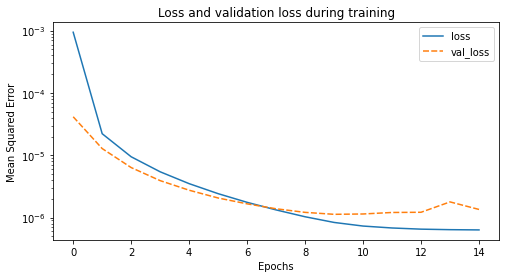

In [14]:
plt.figure(figsize= (8,4))
sns.lineplot(data=pd.DataFrame(history_min.history).iloc[:,[0,2]])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Loss and validation loss during training')

We now compare the predictions to the target.

In [15]:
y_min=data_min.target.iloc[int(0.7*data_min.shape[0])+59:]
prediction_min=model_min.predict(test_data_min).reshape(-1)
pred_min=pd.Series(prediction_min, index=y_min.index)
pred_vs_target=pd.DataFrame({'target':y_min, 'prediction':pred_min})

Text(0.5, 1.0, 'Prediction versus target')

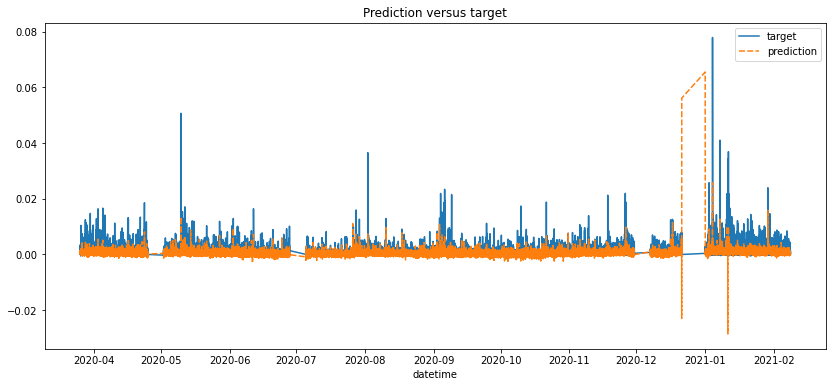

In [16]:
plt.figure(figsize=(14,6))
sns.lineplot(data=pred_vs_target)
plt.title('Prediction versus target')

Text(0.5, 1.0, 'Prediction versus target in the first 300 minutes')

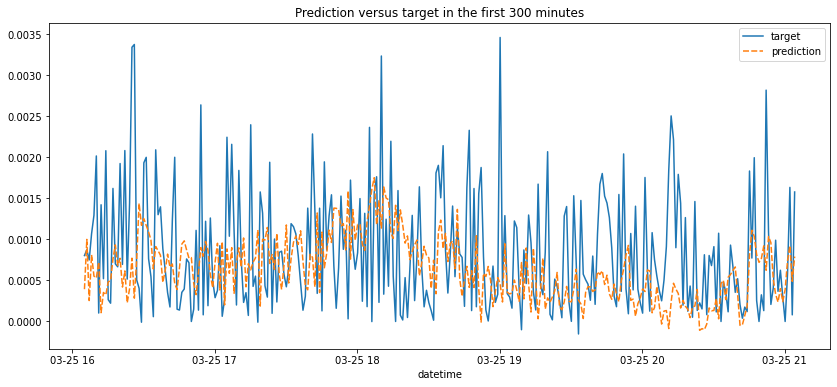

In [17]:
plt.figure(figsize=(14,6))
sns.lineplot(data=pred_vs_target.iloc[:300])
plt.title('Prediction versus target in the first 300 minutes')

In [18]:
y_min.corr(pred_min)

0.3151864781379838

In [19]:
pred_vs_target.agg(['mean', 'std'])

,target,prediction
mean,0.00056,0.000522
std,0.00087,0.000759


In the zoomed-in plot we see that the prediction generally gets the trend right, but rarely the peaks. This is confirmed in the plot of the whole test dataset and also by the fact that the correlation is high, with the prediction having a smaller standard deviation.

### Hourly data

We now look at hourly data. Given that there is only a 60th of the data, the results look surprisinlgy similar to what we got for minutely data.

In [20]:
data_h=data_preprocessing(OHLCV, '1h')

model_h, history_h, test_data_h =fit_lstm_model(
    data=data_h,
    sequence_length=30,
    nr_neurons=4,
    nr_targets=1,
    batch_size=512,
    patience=20
)

Epoch 1/1000
19/19 [==============================] - 4s 90ms/step - loss: 0.0106 - mean_absolute_error: 0.0860 - val_loss: 0.0063 - val_mean_absolute_error: 0.0669
Epoch 2/1000
19/19 [==============================] - 2s 65ms/step - loss: 0.0056 - mean_absolute_error: 0.0624 - val_loss: 0.0032 - val_mean_absolute_error: 0.0462
Epoch 3/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0030 - mean_absolute_error: 0.0446 - val_loss: 0.0017 - val_mean_absolute_error: 0.0329
Epoch 4/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0017 - mean_absolute_error: 0.0326 - val_loss: 0.0010 - val_mean_absolute_error: 0.0251
Epoch 5/1000
19/19 [==============================] - 1s 56ms/step - loss: 0.0011 - mean_absolute_error: 0.0259 - val_loss: 7.4364e-04 - val_mean_absolute_error: 0.0207
Epoch 6/1000
19/19 [==============================] - 1s 64ms/step - loss: 8.4223e-04 - mean_absolute_error: 0.0221 - val_loss: 5.9439e-04 - val_mean_absolute_error: 0.018

19/19 [==============================] - 1s 63ms/step - loss: 3.6277e-05 - mean_absolute_error: 0.0035 - val_loss: 7.9646e-05 - val_mean_absolute_error: 0.0038
Epoch 96/1000
19/19 [==============================] - 1s 65ms/step - loss: 3.9249e-05 - mean_absolute_error: 0.0035 - val_loss: 7.8685e-05 - val_mean_absolute_error: 0.0039
Epoch 97/1000
19/19 [==============================] - 1s 64ms/step - loss: 3.6115e-05 - mean_absolute_error: 0.0035 - val_loss: 7.8357e-05 - val_mean_absolute_error: 0.0039
Epoch 98/1000
19/19 [==============================] - 1s 62ms/step - loss: 3.6193e-05 - mean_absolute_error: 0.0035 - val_loss: 7.7622e-05 - val_mean_absolute_error: 0.0039
Epoch 99/1000
19/19 [==============================] - 1s 66ms/step - loss: 3.4325e-05 - mean_absolute_error: 0.0036 - val_loss: 7.7685e-05 - val_mean_absolute_error: 0.0039
Epoch 100/1000
19/19 [==============================] - 1s 54ms/step - loss: 3.4372e-05 - mean_absolute_error: 0.0035 - val_loss: 7.7448e-05 - v

Epoch 188/1000
19/19 [==============================] - 1s 54ms/step - loss: 3.7135e-05 - mean_absolute_error: 0.0034 - val_loss: 5.9147e-05 - val_mean_absolute_error: 0.0038
Epoch 189/1000
19/19 [==============================] - 1s 53ms/step - loss: 3.3802e-05 - mean_absolute_error: 0.0034 - val_loss: 5.9479e-05 - val_mean_absolute_error: 0.0036
Epoch 190/1000
19/19 [==============================] - 1s 61ms/step - loss: 3.5428e-05 - mean_absolute_error: 0.0033 - val_loss: 5.8586e-05 - val_mean_absolute_error: 0.0037
Epoch 191/1000
19/19 [==============================] - 1s 58ms/step - loss: 3.3695e-05 - mean_absolute_error: 0.0033 - val_loss: 5.8738e-05 - val_mean_absolute_error: 0.0038
Epoch 192/1000
19/19 [==============================] - 2s 65ms/step - loss: 3.4569e-05 - mean_absolute_error: 0.0034 - val_loss: 5.9205e-05 - val_mean_absolute_error: 0.0036
Epoch 193/1000
19/19 [==============================] - 1s 63ms/step - loss: 3.6966e-05 - mean_absolute_error: 0.0034 - val_l

Epoch 235/1000
19/19 [==============================] - 1s 53ms/step - loss: 3.6055e-05 - mean_absolute_error: 0.0034 - val_loss: 5.6681e-05 - val_mean_absolute_error: 0.0036
Epoch 236/1000
19/19 [==============================] - 1s 53ms/step - loss: 3.2342e-05 - mean_absolute_error: 0.0033 - val_loss: 5.5909e-05 - val_mean_absolute_error: 0.0036
Epoch 237/1000
19/19 [==============================] - 1s 59ms/step - loss: 3.4668e-05 - mean_absolute_error: 0.0033 - val_loss: 5.5635e-05 - val_mean_absolute_error: 0.0038
Epoch 238/1000
19/19 [==============================] - 1s 61ms/step - loss: 3.2121e-05 - mean_absolute_error: 0.0034 - val_loss: 5.5908e-05 - val_mean_absolute_error: 0.0038
Epoch 239/1000
19/19 [==============================] - 2s 65ms/step - loss: 3.5349e-05 - mean_absolute_error: 0.0033 - val_loss: 5.5676e-05 - val_mean_absolute_error: 0.0036
Epoch 240/1000
19/19 [==============================] - 2s 69ms/step - loss: 3.1644e-05 - mean_absolute_error: 0.0032 - val_l

Epoch 282/1000
19/19 [==============================] - 1s 61ms/step - loss: 3.2196e-05 - mean_absolute_error: 0.0033 - val_loss: 5.5302e-05 - val_mean_absolute_error: 0.0035
Epoch 283/1000
19/19 [==============================] - 2s 67ms/step - loss: 3.4209e-05 - mean_absolute_error: 0.0033 - val_loss: 5.4140e-05 - val_mean_absolute_error: 0.0036
Epoch 284/1000
19/19 [==============================] - 1s 62ms/step - loss: 3.3052e-05 - mean_absolute_error: 0.0033 - val_loss: 5.4030e-05 - val_mean_absolute_error: 0.0036
Epoch 285/1000
19/19 [==============================] - 1s 63ms/step - loss: 3.5970e-05 - mean_absolute_error: 0.0033 - val_loss: 5.4294e-05 - val_mean_absolute_error: 0.0037
Epoch 286/1000
19/19 [==============================] - 1s 60ms/step - loss: 3.4283e-05 - mean_absolute_error: 0.0033 - val_loss: 5.3519e-05 - val_mean_absolute_error: 0.0037
Epoch 287/1000
19/19 [==============================] - 1s 60ms/step - loss: 3.5385e-05 - mean_absolute_error: 0.0034 - val_l

Epoch 329/1000
19/19 [==============================] - 1s 60ms/step - loss: 3.1893e-05 - mean_absolute_error: 0.0032 - val_loss: 5.2537e-05 - val_mean_absolute_error: 0.0036
Epoch 330/1000
19/19 [==============================] - 1s 56ms/step - loss: 3.5480e-05 - mean_absolute_error: 0.0033 - val_loss: 5.3352e-05 - val_mean_absolute_error: 0.0036
Epoch 331/1000
19/19 [==============================] - 1s 59ms/step - loss: 3.3718e-05 - mean_absolute_error: 0.0033 - val_loss: 5.2611e-05 - val_mean_absolute_error: 0.0036
Epoch 332/1000
19/19 [==============================] - 1s 58ms/step - loss: 3.1783e-05 - mean_absolute_error: 0.0032 - val_loss: 5.3087e-05 - val_mean_absolute_error: 0.0038
Epoch 333/1000
19/19 [==============================] - 1s 64ms/step - loss: 3.4373e-05 - mean_absolute_error: 0.0033 - val_loss: 5.2948e-05 - val_mean_absolute_error: 0.0038
Epoch 334/1000
19/19 [==============================] - 2s 65ms/step - loss: 3.2901e-05 - mean_absolute_error: 0.0033 - val_l

Text(0.5, 1.0, 'Loss and validation loss during training')

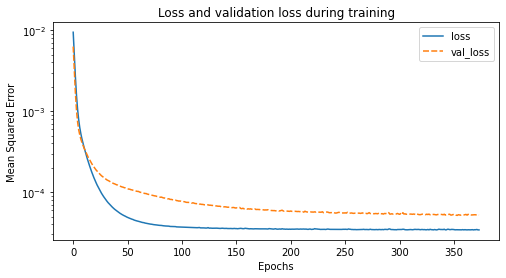

In [21]:
plt.figure(figsize= (8,4))
sns.lineplot(data=pd.DataFrame(history_h.history).iloc[:,[0,2]])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Loss and validation loss during training')

In [22]:
y_h=data_h.target.iloc[int(0.7*data_h.shape[0])+59:]
prediction_h=model_h.predict(test_data_h).reshape(-1)
pred_h=pd.Series(prediction_h, index=y_h.index)
pred_vs_target_h=pd.DataFrame({'target':y_h, 'prediction':pred_h})

Text(0.5, 1.0, 'Prediction versus target')

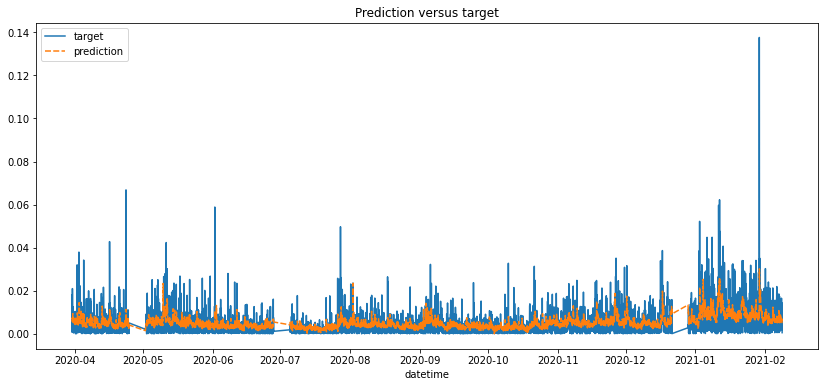

In [23]:
plt.figure(figsize=(14,6))
sns.lineplot(data=pred_vs_target_h)
plt.title('Prediction versus target')

Text(0.5, 1.0, 'Prediction versus target in the first 300 hours')

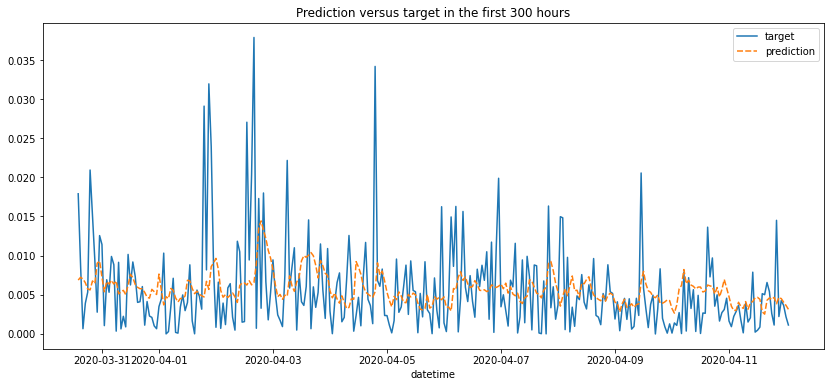

In [24]:
plt.figure(figsize=(14,6))
sns.lineplot(data=pred_vs_target_h.iloc[:300])
plt.title('Prediction versus target in the first 300 hours')

In [25]:
y_h.corr(pred_h)

0.4566880638276994

In [26]:
pred_vs_target_h.agg(['mean', 'std'])

,target,prediction
mean,0.004736,0.005112
std,0.005758,0.002754


## Discussion

Mathematically, we can view the feature windows as a random variable $X$, the target as a random variable $Y$, and the model as a function $f$ depending on $X$. We can then write
$$
Y=f(X)+\epsilon
$$
for some error $\epsilon$. Since for any given observation $X=x$, the function $y\mapsto \mathrm E((Y-y)^2\mid X=x)$ is minimal at $\mathrm E(Y\mid X=x)$ and the loss function is the mean squared error, we expect a well-fitted model to satisfy $f(x) \approx \mathrm E(Y\mid X=x)$ and thus $\mathrm E(\epsilon \mid X=x)=0$ for all $x$. 

Our model seems to predict the trend of $Y$ rather well but is quite conservative overall and rarely predicts peaks in the target, even though those happen frequently. There could be several reasons for this behavior, potentially working in conjuction:

1. The model fails to  properly approximate $\mathrm E(Y\mid X)$.
2. The chosen features have low predictive power over the target.
3. There is a lot of noise. More precisely, $\epsilon\mid X$ has a large standard deviation and/or heavy tails.
4. Anything else?

To study the extent to which (1) is true I would suggest trying to refine the model architecture and optimizing hyperparameters. For (2) it would be interesting to try and add more of the well-established financial indicators to the feature set before trying to engineer new features. At the moment the model relies mostly on OHLCV data and rolling averages of those. I'm a bit wary of adding too many features at once as there is a high risk of both under- and overfitting. 

*Regarding underfitting:* Do you think it makes sense to train the model on data from several coins? My feeling here is that there are some aspects in a financial timeseries that are specific to a particular market, but that there should also be some aspects that are univeral. Are there any hard results on this in the literature? 

Regarding (3) I would like to predict the probabilty density function of $Y\mid X$ instead of simply the mean. The first thing I want to try is fitting a parametric unimodal pdf in the fashion of mixed density networks. Do you know of any other ways of how to do this?





